In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt  
from sklearn.ensemble import RandomForestClassifier 
from sklearn.preprocessing import OneHotEncoder , StandardScaler
import seaborn as sns 
from sklearn.utils.class_weight import compute_class_weight
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report 
import joblib
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle 




In [2]:
train_data = pd.read_csv('../data/fraudTest.csv')
test_data = pd.read_csv('../data/fraudTest.csv')

In [3]:
df = pd.concat([train_data, test_data], ignore_index=True)


In [4]:
df.head() 

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [5]:
df.value_counts('cc_num')

cc_num
6538441737335434       2948
4586810168620942       2932
4745996322265          2924
4587657402165341815    2916
2242542703101233       2856
                       ... 
4087542780207162         18
4883407061576            18
3540416671210051         16
4352307151555405069      14
4295296907373            12
Name: count, Length: 924, dtype: int64

In [6]:
df.groupby('cc_num')['merch_lat'].apply(set)

cc_num
60416207185            {42.528679, 42.806278000000006, 42.128823, 43....
60422928733            {33.256653, 32.990672, 34.235802, 34.035694, 3...
60423098130            {36.322681, 37.755375, 37.908293, 36.414783, 3...
60427851591            {35.905466, 34.792988, 34.945139000000005, 36....
60487002085            {33.167632, 33.209013, 32.139223, 32.765078, 3...
                                             ...                        
4958589671582726883    {38.055398, 37.870199, 39.56458, 38.708543, 37...
4973530368125489546    {34.974994, 35.556492, 35.212292, 35.391866, 3...
4980323467523543940    {44.95802, 44.852787, 44.66101, 43.240536, 44....
4989847570577635369    {34.887458, 33.346398, 33.671277, 34.696671, 3...
4992346398065154184    {40.263647, 40.193536, 42.003643, 40.840735, 4...
Name: merch_lat, Length: 924, dtype: object

In [7]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111438 entries, 0 to 1111437
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1111438 non-null  int64  
 1   trans_date_trans_time  1111438 non-null  object 
 2   cc_num                 1111438 non-null  int64  
 3   merchant               1111438 non-null  object 
 4   category               1111438 non-null  object 
 5   amt                    1111438 non-null  float64
 6   first                  1111438 non-null  object 
 7   last                   1111438 non-null  object 
 8   gender                 1111438 non-null  object 
 9   street                 1111438 non-null  object 
 10  city                   1111438 non-null  object 
 11  state                  1111438 non-null  object 
 12  zip                    1111438 non-null  int64  
 13  lat                    1111438 non-null  float64
 14  long              

In [8]:
cols_to_drop =  ['Unnamed: 0','trans_date_trans_time','job','street','category', 'city','trans_num', 'dob' ,'city_pop', 'unix_time']

In [9]:
df.drop(cols_to_drop , axis=1,  inplace=True)


In [10]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111438 entries, 0 to 1111437
Data columns (total 13 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   cc_num      1111438 non-null  int64  
 1   merchant    1111438 non-null  object 
 2   amt         1111438 non-null  float64
 3   first       1111438 non-null  object 
 4   last        1111438 non-null  object 
 5   gender      1111438 non-null  object 
 6   state       1111438 non-null  object 
 7   zip         1111438 non-null  int64  
 8   lat         1111438 non-null  float64
 9   long        1111438 non-null  float64
 10  merch_lat   1111438 non-null  float64
 11  merch_long  1111438 non-null  float64
 12  is_fraud    1111438 non-null  int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 110.2+ MB


In [11]:
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

In [12]:
df[df['is_fraud'] ==1][:20].to_csv("fraud.csv")

In [13]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111438 entries, 0 to 1111437
Data columns (total 13 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   cc_num      1111438 non-null  int64  
 1   merchant    1111438 non-null  object 
 2   amt         1111438 non-null  float64
 3   first       1111438 non-null  object 
 4   last        1111438 non-null  object 
 5   gender      1111438 non-null  object 
 6   state       1111438 non-null  object 
 7   zip         1111438 non-null  int64  
 8   lat         1111438 non-null  float64
 9   long        1111438 non-null  float64
 10  merch_lat   1111438 non-null  float64
 11  merch_long  1111438 non-null  float64
 12  is_fraud    1111438 non-null  int64  
dtypes: float64(5), int64(3), object(5)
memory usage: 110.2+ MB


In [14]:
df['cc_num'] = df['cc_num'].astype(str)
df['zip'] = df['zip'].astype(str)


In [15]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111438 entries, 0 to 1111437
Data columns (total 13 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   cc_num      1111438 non-null  object 
 1   merchant    1111438 non-null  object 
 2   amt         1111438 non-null  float64
 3   first       1111438 non-null  object 
 4   last        1111438 non-null  object 
 5   gender      1111438 non-null  object 
 6   state       1111438 non-null  object 
 7   zip         1111438 non-null  object 
 8   lat         1111438 non-null  float64
 9   long        1111438 non-null  float64
 10  merch_lat   1111438 non-null  float64
 11  merch_long  1111438 non-null  float64
 12  is_fraud    1111438 non-null  int64  
dtypes: float64(5), int64(1), object(7)
memory usage: 110.2+ MB


In [16]:
categorical_columns = ['cc_num', 'first', 'last','merchant','zip', 'gender', 'state']


In [17]:
# df[categorical_columns] = df[categorical_columns].apply(lambda col: label_encoder.fit_transform(col))
# # Normalize numerical variables using StandardScaler
# numerical_columns = ['amt', 'zip', 'lat', 'long', 'merch_lat', 'merch_long'] 
# df[numerical_columns] = scaler.fit_transform(df[numerical_columns])


In [18]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1111438 entries, 0 to 1111437
Data columns (total 13 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   cc_num      1111438 non-null  object 
 1   merchant    1111438 non-null  object 
 2   amt         1111438 non-null  float64
 3   first       1111438 non-null  object 
 4   last        1111438 non-null  object 
 5   gender      1111438 non-null  object 
 6   state       1111438 non-null  object 
 7   zip         1111438 non-null  object 
 8   lat         1111438 non-null  float64
 9   long        1111438 non-null  float64
 10  merch_lat   1111438 non-null  float64
 11  merch_long  1111438 non-null  float64
 12  is_fraud    1111438 non-null  int64  
dtypes: float64(5), int64(1), object(7)
memory usage: 110.2+ MB


In [19]:
X = df.drop('is_fraud', axis = 1 )
y = df['is_fraud']

In [20]:
def custom_train_test_split(X, y, test_size=0.2, random_state=None):
    """
    Manually split the dataset into training and testing sets.

    Parameters:
    - X: Features (independent variables)
    - y: Target variable (dependent variable)
    - test_size: Proportion of the dataset to include in the test split (default is 0.2)
    - random_state: Seed for random number generation, ensures reproducibility (default is None)

    Returns:
    - x_train, x_test, y_train, y_test
    """
    if random_state is not None:
        np.random.seed(random_state)

    # Shuffle indices
    indices = np.arange(len(X))
    np.random.shuffle(indices)

    # Calculate the split index
    split_index = int((1 - test_size) * len(X))

    # Split the data
    x_train, x_test = X.iloc[indices[:split_index]], X.iloc[indices[split_index:]]
    y_train, y_test = y.iloc[indices[:split_index]], y.iloc[indices[split_index:]]

    return x_train, x_test, y_train, y_test

In [21]:
X_train , X_test , y_train, y_test = custom_train_test_split(X,y , test_size=0.3, random_state=404)

In [22]:
y_train.value_counts()

is_fraud
0    774983
1      3023
Name: count, dtype: int64

In [23]:
X_train 

,cc_num,merchant,amt,first,last,gender,state,zip,lat,long,merch_lat,merch_long
119768,30235268718158,fraud_Macejkovic-Lesch,6.06,Kenneth,Doyle,M,NY,10604,41.0592,-73.7395,40.077445,-74.119713
395460,3545109339866548,fraud_Schmeler Inc,11.68,Keith,Sanders,M,MS,38761,33.4783,-90.5142,33.233483,-89.723344
256471,180084695172649,"fraud_O'Reilly, Mohr and Purdy",29.92,Holly,Mann,F,IL,62075,39.3036,-89.2853,39.941428,-89.703270
382575,4926376199189801,fraud_Barton Inc,207.33,Claire,Davis,F,AR,72529,36.3011,-91.5281,36.320203,-92.043304
567693,30561214688470,fraud_Doyle Ltd,109.20,Gina,Morrison,F,PA,18103,40.5891,-75.4645,40.125612,-75.507219
...,...,...,...,...,...,...,...,...,...,...,...,...
336734,4302475216404898,fraud_Abshire PLC,7.24,Daniel,Cain,M,IA,50421,42.8511,-93.6200,42.724485,-93.180677
100415,4048508450704760,fraud_Haley Group,179.69,Cheryl,Melton,F,NE,68638,41.3660,-98.0054,41.084506,-97.287254
603801,3533012926413100,fraud_Botsford Ltd,4.79,Megan,Bernard,F,NY,13304,43.2237,-75.1612,43.132154,-74.272091
598910,342952484382519,fraud_Cummings LLC,69.58,Kayla,Jones,F,CT,6024,42.0158,-73.2913,42.503521,-73.580085


In [24]:
# Calculate class weights for the imbalanced problem 
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)
class_weight_dict = dict(zip([0, 1], class_weights))

In [25]:
class_weight_dict

{0: 0.5019503653628531, 1: 128.68111147866358}

In [26]:
# Define categorical and numerical columns
categorical_columns = ['cc_num', 'merchant', 'first', 'last', 'gender', 'state', 'zip']
numerical_columns = ['amt', 'lat', 'long', 'merch_lat', 'merch_long']

In [32]:
# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(), categorical_columns)
    ]
)

In [31]:
# Flies are used later to make the exploration about the model 
X_train.to_csv('../data/processed/X.csv')
y_train.to_csv("../data/processed/y.csv")

In [33]:
preprocessor.fit_transform(X_train)

<778006x3398 sparse matrix of type '<class 'numpy.float64'>'
	with 9336072 stored elements in Compressed Sparse Row format>

In [35]:
# Save the preprocessor to a pickle file
with open('../model/preprocessor.pkl', 'wb') as file:
    pickle.dump(preprocessor, file)

In [36]:
# Create the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42, class_weight=class_weight_dict))
])

In [37]:
# Fit the classifier on the training data
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['amt', 'lat', 'long',
                                                   'merch_lat', 'merch_long']),
                                                 ('cat', OneHotEncoder(),
                                                  ['cc_num', 'merchant',
                                                   'first', 'last', 'gender',
                                                   'state', 'zip'])])),
                ('classifier',
                 RandomForestClassifier(class_weight={0: 0.5019503653628531,
                                                      1: 128.68111147866358},
                                        random_state=42))])

In [38]:
def custom_confusion_matrix(y_true, y_pred, num_classes):
    """
    Calculate the confusion matrix.

    Parameters:
    - y_true: True class labels
    - y_pred: Predicted class labels
    - num_classes: Number of classes

    Returns:
    - Confusion matrix as a 2D numpy array
    """
    confusion_matrix = [[0] * num_classes for _ in range(num_classes)]

    for true_label, pred_label in zip(y_true, y_pred):
        confusion_matrix[true_label][pred_label] += 1

    return confusion_matrix

In [39]:
y_pred = pipeline.predict(X_test)


In [40]:
report_cls = classification_report(y_test, y_pred)
print(report_cls)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    332165
           1       0.96      0.87      0.91      1267

    accuracy                           1.00    333432
   macro avg       0.98      0.93      0.96    333432
weighted avg       1.00      1.00      1.00    333432



In [41]:
cm = custom_confusion_matrix(y_test, y_pred, 2)

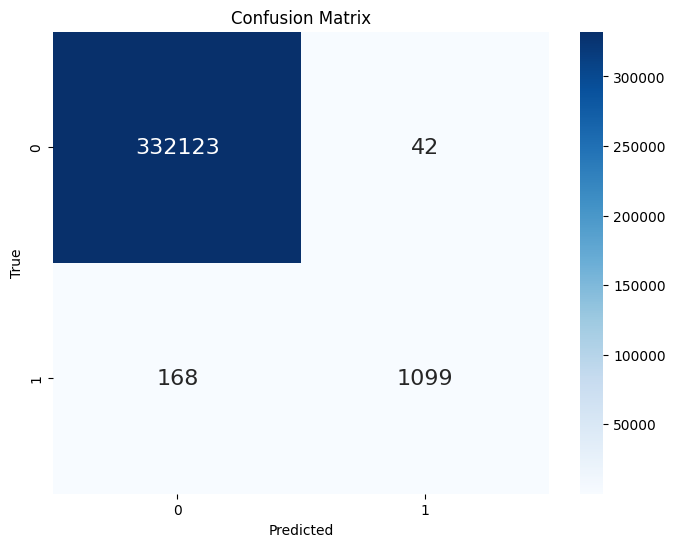

In [42]:
# Convert to a numpy array for Seaborn heatmap
cm_np = np.array(cm)

# Plot the confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm_np, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 16})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [44]:
# Function to save the preprocessing pipeline
def save_pipeline(pipeline, pipeline_path="../model/model_pipeline.pkl"):
    with open(pipeline_path, "wb") as file:
        pickle.dump(pipeline, file)

In [45]:
save_pipeline(pipeline)